# Обучение с учителем

Алгоритмы, которые требуют размеченной выборки для обучения, называются алгоритмами обучения с учителем. "Разметить выборку" означает поставить в соответствие объекту обучающей выборки значение целевой переменной (таргета) которое алгоритм машинного обучения  должен "выучить"

Обычно большие объёмы дорого размечать - можно пользоваться сервисами типа "Яндекс.Толока", либо своими силами размечать.

# Классификация

## Постановка задачи классификации

Классификация - задача для алгоритмов машинного обучения восстановить на объектах обучающей выборки **метки классов**. Классы - конечный (дискретный) набор целевых переменных. Например, в задаче фильтрации спама два класса: спам (метка $1$) и не спам (метка $0$)

Существует бинарная классификация (когда классов всего два: $0$ и $1$) и мультиклассовая классификация, когда классов несколько. Если научились классифицировать на два класса, то и на несколько получиться: метод One vs All 

Продемострируем работу алгоритма классификации на данных по оттоку, которые содержатся в файле `data/client_segmentation.csv`. В файле содержится информация по клиентам оператора связи о том, как изменилось потребление услуг оператора за два месяца:
* call_diff доля звонков
* sms_diff доля смс
* доля интернет-трафика traffic_diff

Все показатели вычисляются по формуле

$$
\frac{\text{new_value}-\text{old_value}}{\text{old_value}}
$$

В последней колонке `customes_class` содержится метка по оттоку:
* $0$ - активный пользователя
* $1$ - "спящий" пользователь (редко пользуется услугами)
* $2$ - пользователь, который ушел в отток

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

%matplotlib inline
np.set_printoptions(precision=4)

df_source = pd.read_csv(
    'data/client_segmentation.csv', 
    dtype={'call_diff': np.float32, 'call_diff': np.float32, 'traffic_diff': np.float32, 'customes_class': np.uint16}
)
X = df_source[['call_diff','sms_diff','traffic_diff']].values
y = df_source.customes_class.values

df_source.head(5)

,call_diff,sms_diff,traffic_diff,customes_class
0,-0.666421,0.444911,-0.273538,0
1,-0.889273,-0.537896,-1.959469,2
2,-0.841503,0.846665,0.727606,0
3,1.389749,0.390911,1.789246,1
4,-1.228211,-1.375899,-1.434209,2


<AxesSubplot:>

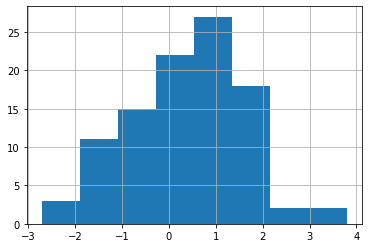

In [4]:
df_source.sms_diff.hist(bins=8)

In [5]:
df_source.customes_class.value_counts()

0    34
2    33
1    33
Name: customes_class, dtype: int64

Построим наивный байесовский классификатор - мы уже использовали этот алгоритм в начале курса, когда говорили про теорию вероятностей.

Оценим качество классификатора: сколько пользователей предсказали правильно

In [6]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB() # создаём экземпляр класса
naive_bayes.fit(X, y) # обучение модели
predicted_classes = naive_bayes.predict(X) # предсказание (эксплуатация модели)

accuracy = (predicted_classes == y).sum() / len(y)

print(f'Точность предсказаний: {accuracy}')

Точность предсказаний: 0.95


In [7]:
predicted_classes == y

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

Можно вытащить, например, априорные вероятности классов

In [8]:
print(naive_bayes.class_prior_)

[0.34 0.33 0.33]


## Алгоритмы классификации

Алгоритмы приводятся в виде ссылок на документацию sklearn

### [Наивный Байесовский классификатор](https://scikit-learn.org/stable/modules/naive_bayes.html)

Классификатор основан на вероятностном подходе: подсчёт частот встречаемости фичей.

Очень просто реализовать, поэтому работает достаточно быстро. Применим  на больших объёмах данных в случае, когда количество фичей не очень большое.

### [Метод $K$ ближайших соседей](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

Т.н. "ленивый" (lazy algorithm) алгоритм классификации, который работает за два шага:

* запоминает объекты обучающей выборки и их классы
* в момент предсказания для объекта находит $k$ самых близких объектов из обучающей выборки и присваивает новому объекту класс большинства его "соседей"



### [Логистическая регрессия](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

Алгоритм, основанный на идеях линейной регрессии. Применим для бинарной классификации, на выходе выдаёт вероятность того, что объект принадлежит классу $1$, которая вычисляется по формуле

$$
P(y==1 | x) = \frac{1}{1+e^{z}}
$$

Где $z$ - линейная комбинация фичей объекта
$$
z = \theta^T x = \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_n x_n
$$

Обучение сводится к вычислению оптимального набора $\theta = [\theta_1, \theta_2, \ldots, \theta_n]$

Статья [пережёвываем логистическую регрессию](https://m.habr.com/ru/post/485872/)_


**Примечание**: другой пример линейного классификатора - [машина опорных векторов](https://scikit-learn.org/stable/modules/svm.html#classification)

В этом алгоритме мы обучаем вектор весов $W$ таким образом, чтобы прямая $y=W^TX$, задаваемая этими весами, проходила на максимальном удалении от точек обоих классов

![svm_hyperplane.png](img/svm_hyperplane.png)

Отличная [статья на Хабре про SVM](https://habr.com/ru/company/ods/blog/484148/) 


### [Дерево принятия решений]()

Дерево принятия решений в задачах классификации можно представить как последовательность вопросов о фичах объекта, которая приводит к однозначному определению класса объекта. Каждый следующий вопрос зависит от того, какой ответ был получен на предыдущем шаге

Как каждый такой вопрос - это проверка признака по некоторому "порогу разбиения" и разбиение выборки на две части по этому порогу. Порог разбиения выбирается таким образом, чтобы минимизировать энтропию (т.е. уменьшить неопределенность) в двух получившихся частях выборки.

Более подробно ( в т.ч. про энтропию) можно почитать в [Статье от ODS](https://habr.com/ru/company/ods/blog/322534)

In [9]:
from sklearn import tree

clf = tree.DecisionTreeClassifier().fit(X, y)

Предсказания одного дерева получаем по формуле

In [10]:
predicted_classes = clf.predict(X)

accuracy = (predicted_classes == y).sum() / len(y)

print(f'Точность предсказаний: {accuracy}')

Точность предсказаний: 1.0


Визуализация дерева принятия решений

[Text(494.5909090909091, 489.24, 'X[0] <= 0.259\ngini = 0.667\nsamples = 100\nvalue = [34, 33, 33]'),
 Text(304.3636363636364, 380.52000000000004, 'X[1] <= 0.629\ngini = 0.528\nsamples = 68\nvalue = [33, 2, 33]'),
 Text(152.1818181818182, 271.8, 'X[2] <= -0.411\ngini = 0.26\nsamples = 39\nvalue = [6, 0, 33]'),
 Text(76.0909090909091, 163.08000000000004, 'gini = 0.0\nsamples = 26\nvalue = [0, 0, 26]'),
 Text(228.27272727272728, 163.08000000000004, 'X[1] <= -0.702\ngini = 0.497\nsamples = 13\nvalue = [6, 0, 7]'),
 Text(152.1818181818182, 54.360000000000014, 'gini = 0.0\nsamples = 7\nvalue = [0, 0, 7]'),
 Text(304.3636363636364, 54.360000000000014, 'gini = 0.0\nsamples = 6\nvalue = [6, 0, 0]'),
 Text(456.54545454545456, 271.8, 'X[0] <= -0.32\ngini = 0.128\nsamples = 29\nvalue = [27, 2, 0]'),
 Text(380.4545454545455, 163.08000000000004, 'gini = 0.0\nsamples = 27\nvalue = [27, 0, 0]'),
 Text(532.6363636363636, 163.08000000000004, 'gini = 0.0\nsamples = 2\nvalue = [0, 2, 0]'),
 Text(684.8181

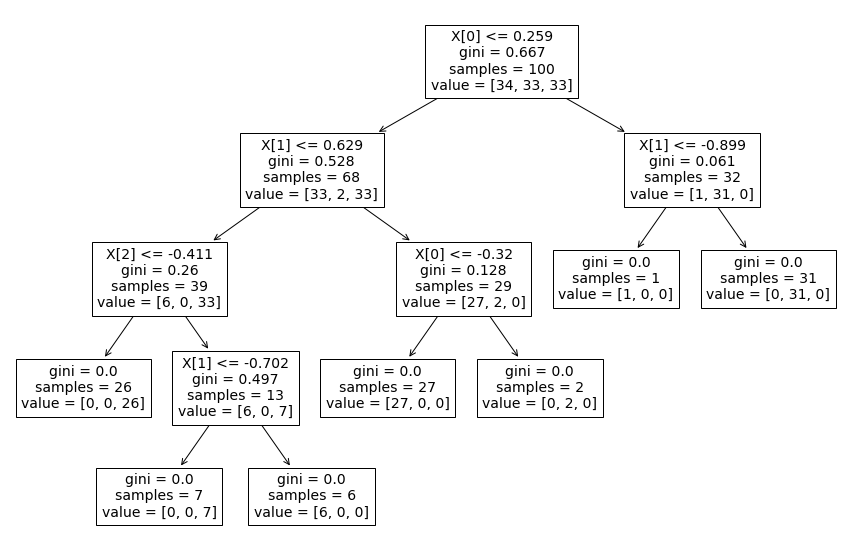

In [14]:
%matplotlib inline

plt.figure(figsize=(15, 10))
tree.plot_tree(clf)

### [Классификатор на случайных деревьях](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

Строим большое количество случайных деревьев, а итоговое предсказание - результат "голосования" деревьев

![random_forest_introduction.jpg](img/random_forest_introduction.jpg)


Почему это работает?

Если у каждого дерева вероятность правильного предсказания выше, чем 0.5 то у чем больше таких деревьев тем выше вероятнсть правильного ответа

## Метрики классификации

Все метрики классификации основаны на следующей таблице, которая содержит возможные исходы работы классификатора: ошибочные и корректные.

![confusion_matrix.png](img/confusion_matrix.png)

В таблице 4 исхода применения классификатора:

* `true positive`: класс $1$ предсказали правильно
* `false positive`: класс $1$ предсказали неправильно
* `true negative`: класс $0$ предсказали правильно
* `false negative`: класс $0$ предсказали неправильно

На числах, которые находятся в ячейках таблицы можно построить огромное количество метрик

Для начала посчитаем собственно confusion matrix

Кoличество объектов в тестовой выборке: 33


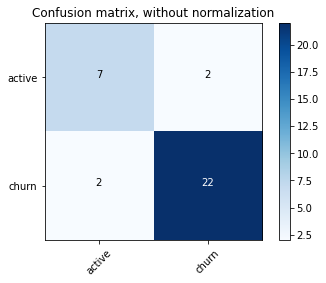

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools

# сводим задачу к бинарной классификации
df_source = pd.read_csv(
    'data/client_segmentation.csv', 
    dtype={'call_diff': np.float32, 'call_diff': np.float32, 'traffic_diff': np.float32, 'customes_class': np.uint16}
)
df_source[(df_source.customes_class==2) & (df_source.call_diff>1.1)] = 0
df_source[(df_source.customes_class==2) & (df_source.call_diff<=1.1)] = 1
X = df_source[['call_diff','sms_diff','traffic_diff']].values
y = df_source.customes_class.values

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
naive_bayes.fit(X_train, y_train)
y_pred = naive_bayes.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(
    conf_matrix,
    classes=['active', 'churn'],
    title='Confusion matrix, without normalization'
)
print(f'Кoличество объектов в тестовой выборке: {len(y_pred)}')

Активно используются следующие метрики

**Accuracy**

$$
\frac{TP + TN}{TP + TN + FP + FN}
$$

**Precision**
$$
\frac{TP}{TP + FP}
$$

**Recall**
$$
\frac{TP}{TP + FN}
$$

**F1-score**
$$
2\frac{precision\cdot recall}{precision + recall}
$$

**Logistic Loss**
$$
-\frac{1}{l}\sum_{i=1}^{l}\left(y_i \log\hat{y}_i + (1-y_i) \log(1-\hat{y}_i)\right)
$$


Про метрики есть хороший разбор на хабре [в статье про метрики](https://habr.com/ru/company/ods/blog/328372/)

In [19]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score

for f in [accuracy_score, precision_score, recall_score, f1_score, log_loss]:
    print(f'{f.__name__}:\t{f(y_test, y_pred)}')

accuracy_score:	0.8787878787878788
precision_score:	0.9166666666666666
recall_score:	0.9166666666666666
f1_score:	0.9166666666666666
log_loss:	4.186566811348581


## Домашнее задание

Найдите лучший классификатор по метрике `f1_score`

In [40]:
from sklearn.tree  import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


classifiers = [
    DecisionTreeClassifier().fit(X_train, y_train),
    GaussianNB().fit(X_train, y_train),
    KNeighborsClassifier().fit(X_train, y_train),
    LogisticRegression().fit(X_train, y_train),
    RandomForestClassifier().fit(X_train, y_train)
]
y_pred = [cl.predict(X_test) for cl in classifiers]

f1_results = [f1_score(y_test, y_pred[i]) for i in range(len(y_pred))]


for i in range(len(y_pred)):
    print(str(classifiers[i])[:-2], '-', f1_results[i])

best_score = f1_results.index(max(f1_results))  # индекс массива лучшего классификатора
print(f'\nЛучший классификатор по метрике f1-score: {str(classifiers[best_score])[:-2]} - {max(f1_results)}')

DecisionTreeClassifier - 0.9583333333333334
GaussianNB - 0.9166666666666666
KNeighborsClassifier - 0.9583333333333334
LogisticRegression - 0.9583333333333334
RandomForestClassifier - 0.9583333333333334

Лучший классификатор по метрике f1-score: DecisionTreeClassifier - 0.9583333333333334


# Регрессия

Регрессия - это семейство алгоритмов машинного обучения с учителем, цель которых состоит в востановлении **непрерывной** зависимости целевой переменной от фичей.

Допустим, у нас есть нормализованные данные по количеству просмотров контента в онлайн-кинотеатре ivi

* в датасете всего одна фича: время, когда было сделано наблюдение
* целевая переменная - количество просмотров в этот момент времени

Мы хотим научиться предсказывать количество просмотров (напрерывную переменную) по времения суток

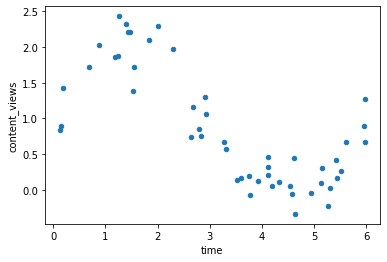

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('data/content_views_toy_set.csv', encoding='utf8')
df.plot.scatter(x='time', y='content_views')
plt.show()

## Линейная регрессия

Впервые термин *регрессия* в статистике был использован английским исследователем Френсисом Гальтоном (1886) в  исследовании вопроса наследования физических характеристик человека (конкретно - роста человека). Было обнаружено, что в целом сыновья высоких отцов, оказались более высокими, чем сыновья отцов с низким ростом. Более интересным было то, что разброс в росте сыновей был меньшим, чем разброс в росте отцов. Так проявлялась тенденция возвращения роста сыновей к среднему (regression to mediocrity), то есть «регресс».

Реализация этого алгоритма есть в библиотеке sklearn

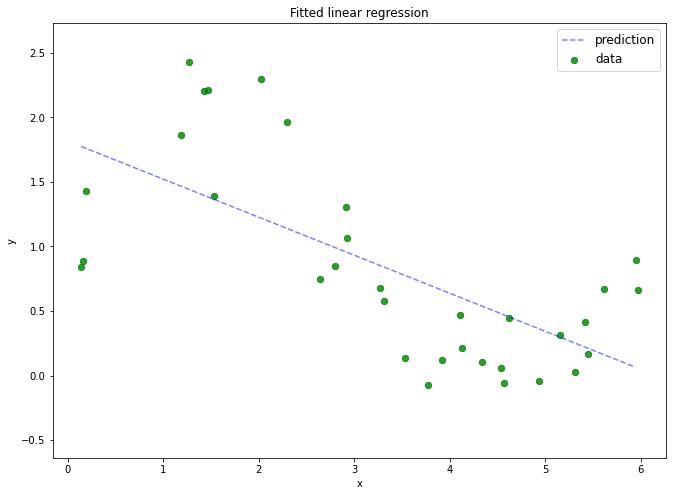

In [42]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = df['time'].values
y = df['content_views'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
reg = LinearRegression().fit(X_train.reshape(-1, 1), y_train)

# строим график
margin = 0.3
support = np.arange(X.min(), X.max(), step=0.1)

# строим предсказание
y_hat = reg.predict(support.reshape(-1, 1))

plt.figure(figsize=(11, 8))
plt.plot(support, y_hat, 'b--', alpha=0.5, label='prediction')
plt.scatter(X_train, y_train, 40, 'g', 'o', alpha=0.8, label='data')
plt.xlim(X.min() - margin, X.max() + margin)
plt.ylim(y.min() - margin, y.max() + margin)
plt.legend(loc='upper right', prop={'size': 12})
plt.title('Fitted linear regression')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Если вспомнить модель линейной регрессии, то обучение модели сводится к нахождению коэффициентов $w_1,\ldots,w_n$:
$$
\forall x_i: h(x) = w_0 + w_1x_i^1 + \ldots + w_nx_i^n = \sum_{j=1}^{n}w_jx_i^j = \overline{x}_i^T\overline{w}
$$

"Достать" коэффициенты из модели можно через аттрибут `coef_`:

In [43]:
print(
    f'Коэффициенты линейной регрессии w={reg.coef_},',
    f'качество модели {reg.score(X_test.reshape(-1,1), y_test)}'
)

Коэффициенты линейной регрессии w=[-0.2942], качество модели 0.5831098740865217


Линейная регрессия очень хорошо интерпретируется: чем больше по модулю значение коэффициента $w_i$, тем сильнее фича $x_i$ влияет на предсказания модели.

Кажется, что линейная комбинация фичей сильно ограничивает модель и не позволяет улавливать сложные зависимости.

Чтобы модель улавливала нелинейные зависимости, мы можем добавить в датасет степени исходной переменной. Допустим, построим предсказания на полиноме пятой степени:

In [44]:
X_train

array([5.6102, 5.9498, 2.2894, 1.4277, 2.6416, 3.5284, 4.541 , 4.1259,
       0.1384, 5.4467, 3.7737, 4.3334, 1.1824, 4.107 , 1.5346, 4.6228,
       0.1572, 2.9246, 0.1887, 5.4152, 4.5724, 3.3146, 5.1574, 1.4717,
       3.2705, 2.7988, 5.9687, 2.912 , 1.2705, 5.3083, 2.0189, 3.9183,
       4.9372])

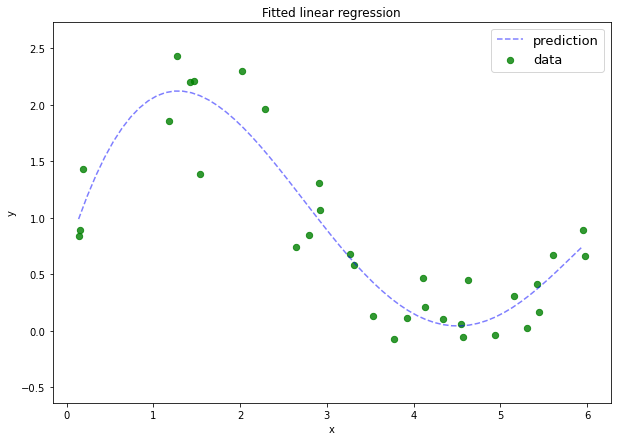

In [33]:
def generate_degrees(source_data: list, degree: int):
    """Функция, которая принимает на вход одномерный массив, а возвращает n-мерный
    Для каждой степени от 1 до  degree возводим x в эту степень
    """
    return np.array([
          source_data**n for n in range(1, degree + 1)  
    ]).T

X_train_5 = generate_degrees(X_train, 5)
X_test_5 = generate_degrees(X_test, 5)
reg_5 = LinearRegression().fit(X_train_5, y_train)

# строим график
margin = 0.3
support = np.arange(X.min(), X.max(), step=0.1)

X_test_support = generate_degrees(support, 5)
y_hat = reg_5.predict(X_test_support)

plt.figure(figsize=(10, 7))
plt.plot(support, y_hat, 'b--', alpha=0.5, label='prediction')
plt.scatter(X_train, y_train, 40, 'g', 'o', alpha=0.8, label='data')
plt.xlim(X.min() - margin, X.max() + margin)
plt.ylim(y.min() - margin, y.max() + margin)
plt.legend(loc='upper right', prop={'size': 13})
plt.title('Fitted linear regression')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Посмотрим на модель, которая у нас обучилась - вместо одной фичи в матрице **объекты $\times$ признаки** стало пять фичей

In [34]:
print(
    f'коэффициенты линейной регрессии w={reg_5.coef_},\n',
    f'качество модели {reg_5.score(X_test_5, y_test):.4f}'
)

коэффициенты линейной регрессии w=[ 2.4828e+00 -1.1939e+00  8.7173e-02  2.1565e-02 -2.3891e-03],
 качество модели 0.9123


### Домашнее задание.

Пользуясь методом `.score` подберите наилучшее значение степени полинома

Наилучшее значение степени полинома: 3
score = 0.9313123641187704


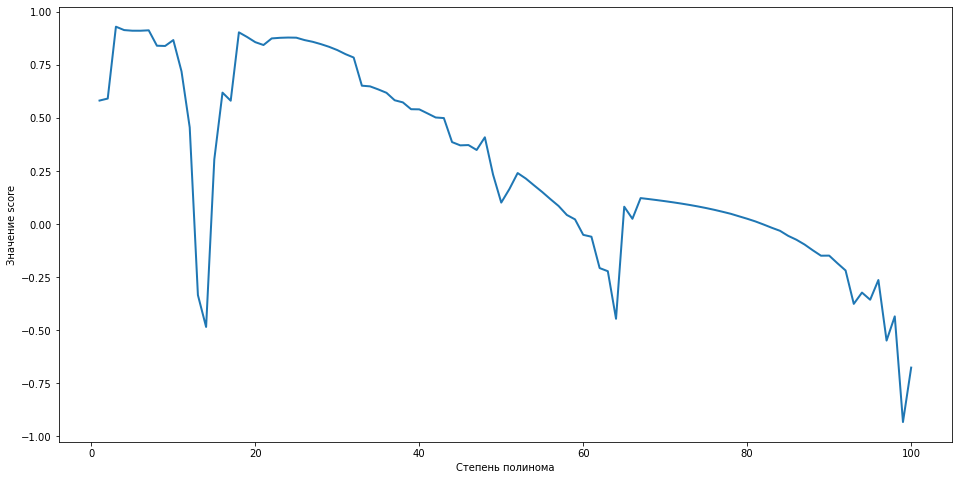

In [45]:
scores = []
start = 1
stop = 100

for i in range(start, stop + 1):
    X_train_i = generate_degrees(X_train, i)
    X_test_i = generate_degrees(X_test, i)
    reg_i = LinearRegression().fit(X_train_i, y_train)
    
    scores.append(reg_i.score(X_test_i, y_test))

best_pol = scores.index(max(scores)) + start  # лучшее значение полинома
print(f'Наилучшее значение степени полинома: {best_pol}\nscore = {max(scores)}')

indexes = np.arange(len(scores)) + 1
plt.figure(figsize=(16, 8))
plt.plot(indexes, scores, linewidth=2)
plt.xlabel('Степень полинома')
plt.ylabel('Значение score')
plt.show()

## Случайный лес

Алгорим случайного можно применять для регрессии аналогично тому, как он применяется для классификации

* рандомизировано построить несколько деревьев
* каждое дерево независимо предсказывает значение в точке
* итоговое предсказание - усреднённое значение предсказаний деревьев ансамбля

In [35]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10).fit(X_train.reshape(-1, 1), y_train)
print(
    f'коэффициенты важности фичей w={rf.feature_importances_},',
    f'качество модели {rf.score(X_train.reshape(-1, 1), y_train):.4f}'
)

коэффициенты важности фичей w=[1.], качество модели 0.9756


# Выводы

* в задаче обучения с учителем обязательно нужно тратить время на разметку
* проблема дисбаланса классов
* можно слишком сильно подогнать модель под обучающую выборку - это явление переобучения, о нём поговорим в следующих занятиях